<center>

## Aprendizaje No Supervisado DiploDatos
    Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni
## Agrupamiento con el FIFA 2021 dataset


Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Exploración de la Base](#2.-Exploración-de-la-base)
3. [Preparación de los datos](#3.-Preparación-de-los-datos)
4. [Clustering Visual](#3.-Exploratorio-Visual-para-Clustering)

## 1.-Inicialización-del-entorno

**Empezamos cargando algunas herramientas para cargar los datos y manipularlos.**

In [16]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

**Para visualización usaremos principalmente plotly, también seaborn y matplotlib.**

In [17]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

## 2.-Exploración-de-la-base

In [18]:
df = df = pd.read_csv("./players_21.csv")
df.head(4)

sofifa_id                                         player_url  \
0     158023  https://sofifa.com/player/158023/lionel-messi/...   
1      20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
2     200389  https://sofifa.com/player/200389/jan-oblak/210002   
3     188545  https://sofifa.com/player/188545/robert-lewand...   

          short_name                            long_name  age         dob  \
0           L. Messi       Lionel Andrés Messi Cuccittini   33  1987-06-24   
1  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   35  1985-02-05   
2           J. Oblak                            Jan Oblak   27  1993-01-07   
3     R. Lewandowski                   Robert Lewandowski   31  1988-08-21   

   height_cm  weight_kg nationality          club_name  \
0        170         72   Argentina       FC Barcelona   
1        187         83    Portugal           Juventus   
2        188         87    Slovenia    Atlético Madrid   
3        184         80      Poland  FC Bayern München   

              league_name  league_rank  overall  potential  value_eur  \
0  Spain Primera Division          1.0       93         93   67500000   
1         Italian Serie A          1.0       92         92   46000000   
2  Spain Primera Division          1.0       91         93   75000000   
3    German 1. Bundesliga          1.0       91         91   80000000   

   wage_eur player_positions preferred_foot  international_reputation  \
0    560000       RW, ST, CF           Left                         5   
1    220000           ST, LW          Right                         5   
2    125000               GK          Right                         3   
3    240000               ST          Right                         4   

   weak_foot  skill_moves      work_rate             body_type real_face  \
0          4            4     Medium/Low                 Messi       Yes   
1          4            5       High/Low            C. Ronaldo       Yes   
2          3            1  Medium/Medium  PLAYER_BODY_TYPE_259       Yes   
3          4            4    High/Medium  PLAYER_BODY_TYPE_276       Yes   

   release_clause_eur                                        player_tags  \
0         138400000.0  #Dribbler, #Distance Shooter, #FK Specialist, ...   
1          75900000.0  #Aerial Threat, #Dribbler, #Distance Shooter, ...   
2         159400000.0                                                NaN   
3         132000000.0              #Distance Shooter, #Clinical Finisher   

  team_position  team_jersey_number loaned_from      joined  \
0           CAM                10.0         NaN  2004-07-01   
1            LS                 7.0         NaN  2018-07-10   
2            GK                13.0         NaN  2014-07-16   
3            ST                 9.0         NaN  2014-07-01   

   contract_valid_until nation_position  nation_jersey_number  pace  shooting  \
0                2021.0              RW                  10.0  85.0      92.0   
1                2022.0              LS                   7.0  89.0      93.0   
2                2023.0              GK                   1.0   NaN       NaN   
3                2023.0             NaN                   NaN  78.0      91.0   

   passing  dribbling  defending  physic  gk_diving  gk_handling  gk_kicking  \
0     91.0       95.0       38.0    65.0        NaN          NaN         NaN   
1     81.0       89.0       35.0    77.0        NaN          NaN         NaN   
2      NaN        NaN        NaN     NaN       87.0         92.0        78.0   
3     78.0       85.0       43.0    82.0        NaN          NaN         NaN   

   gk_reflexes  gk_speed  gk_positioning  \
0          NaN       NaN             NaN   
1          NaN       NaN             NaN   
2         90.0      52.0            90.0   
3          NaN       NaN             NaN   

                                       player_traits  attacking_crossing  \
0  Finesse Shot, Long Shot Taker (AI), Speed Drib...                  8

In [19]:
len(df)

18944

In [20]:
print(df.columns)
print(len(df.columns))

Index(['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob',
       'height_cm', 'weight_kg', 'nationality', 'club_name',
       ...
       'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb'],
      dtype='object', length=106)
106


La variable **'Overall'** se calcula usando otras variables de desempeño del jugador (skills_ratings).

La variable 'Overall' es discreta, así como las otras de desempeño según habilidad ('Crossing',
       'Finishing', 'HeadingAccuracy', etc.), tomando valores enteros entre 0 y 100
       
Miramos ahora los mejores jugadores por posicion, usando las variables 'Overall' y 'Position'. 

**Realizamos el histograma de la variable "Overall" (Desempeño global)**

<AxesSubplot:>

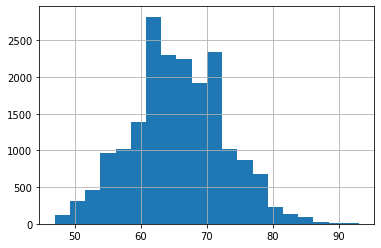

In [21]:
df['overall'].hist(bins = 20)

In [22]:
# A diferencia del dataset usado en clase del fifa 2019, en este cada jugador puede tener asignada mas de una posicion
# Por eso para realizar el conteo de las posiciones tomamos la primera de las posiciones asignada a cada jugador
df['first_position'] = df['player_positions'].apply(lambda x: x.split(', ')[0])

In [23]:
best_players_per_position=df.iloc[df.groupby(df['first_position'])['overall'].idxmax()][['first_position','short_name','overall']]
best_players_per_position

first_position           short_name  overall
5              CAM         K. De Bruyne       91
8               CB          V. van Dijk       90
17             CDM             Casemiro       89
15              CF           K. Benzema       89
24              CM             T. Kroos       88
2               GK             J. Oblak       91
33              LB         A. Robertson       87
46              LM               H. Son       87
4               LW            Neymar Jr       91
300            LWB                Jonny       81
29              RB  T. Alexander-Arnold       87
28              RM            J. Sancho       87
0               RW             L. Messi       93
255            RWB      Mário Fernandes       82
1               ST    Cristiano Ronaldo       92

Conteos por posiciones

In [24]:
pd.DataFrame(df.first_position.value_counts().sort_index())

first_position
CAM            1148
CB             3252
CDM            1514
CF              115
CM             2241
GK             2084
LB             1402
LM             1069
LW              420
LWB             100
RB             1363
RM             1065
RW              438
RWB              88
ST             2645

In [25]:
club_avg_overall=df.groupby("club_name")["overall"].mean().reset_index().sort_values("overall",ascending=False)
club_avg_overall.head(8)

club_name    overall
216  FC Bayern München  81.045455
489        Real Madrid  79.250000
131            Chelsea  79.212121
214       FC Barcelona  78.909091
374          Liverpool  78.575758
330              Inter  78.000000
387  Manchester United  77.818182
386    Manchester City  77.484848

## 2.-Preparación-de-los-datos

**Retiramos jugadores con bajo Desempeño global ("Overall"), reducimos el tamaño de la base**

**y consideramos Variables de desempeño por habilidad (skills_ratings)**

In [26]:
n=10000 #cantidad de jugadores a considerar

df_n=df.loc[:n] #se reduce la base a los n primeros jugadores

df_n=df_n[(df_n['overall']>70)]

skills_ratings = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 
                  'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 
                  'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 
                  'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 
                  'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 
                  'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
                  'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving',
                  'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
print(len(skills_ratings), 'variables numéricas de desempeño según habilidad')

34 variables numéricas de desempeño según habilidad


https://www.fifplay.com/encyclopedia/
En ese link está lo que significa cada skill

**Se crea el jugador perfecto para ver a donde se ubica en nuestra visualización**

In [27]:
MachineGunDict={'Name':'MachineGun','overall':99}
for skills in skills_ratings:
    MachineGunDict[skills]=99
    
df_n=df_n.append(MachineGunDict,ignore_index=True)

In [61]:
df_skills=df_n[skills_ratings] #base, sólo con desempeños según habilidad (numéricas)
df_skills_pos = df_n[skills_ratings + ['first_position']]

In [29]:
df_skills.head(4)

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                  85                   95                          70   
1                  84                   95                          90   
2                  13                   11                          15   
3                  71                   94                          85   

   attacking_short_passing  attacking_volleys  skill_dribbling  skill_curve  \
0                       91                 88               96           93   
1                       82                 86               88           81   
2                       43                 13               12           13   
3                       84                 89               85           79   

   skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0                 94                  91                  96   
1                 76                  77                  92   
2                 14                  40                  30   
3                 85                  70                  88   

   movement_acceleration  movement_sprint_speed  movement_agility  \
0                     91                     80                91   
1                     87                     91                87   
2                     43                     60                67   
3                     77                     78                77   

   movement_reactions  movement_balance  power_shot_power  power_jumping  \
0                  94                95                86             68   
1                  95                71                94             95   
2                  88                49                59             78   
3                  93                82                89             84   

   power_stamina  power_strength  power_long_shots  mentality_aggression  \
0             72              69                94                    44   
1             84              78                93                    63   
2             41              78                12                    34   
3             76              86                85                    81   

   mentality_interceptions  mentality_positioning  mentality_vision  \
0                       40                     93                95   
1                       29                     95                82   
2                       19                     11                65   
3                       49                     94                79   

   mentality_penalties  mentality_composure  defending_marking  \
0                   75                   96                NaN   
1                   84                   95                NaN   
2                   11                   68                NaN   
3                   88                   88                NaN   

   defending_standing_tackle  defending_sliding_tackle  goalkeeping_diving  \
0                         35                        24                   6   
1                         32                        24                   7   
2                         12                        18                  87   
3                         42                        19                  15   

   goalkeeping_handling  goalkeeping_kicking  goalkeeping_positioning  \
0                    11                   15                       14   
1                    11                   15                       14   
2                    92                   78                       90   
3                     6                   12                        8   

   goalkeeping_reflexes  
0                     8  
1                    11  
2                    90  
3                    10

In [57]:
df_skills.isna().sum()

attacking_crossing               0
attacking_finishing              0
attacking_heading_accuracy       0
attacking_short_passing          0
attacking_volleys                0
skill_dribbling                  0
skill_curve                      0
skill_fk_accuracy                0
skill_long_passing               0
skill_ball_control               0
movement_acceleration            0
movement_sprint_speed            0
movement_agility                 0
movement_reactions               0
movement_balance                 0
power_shot_power                 0
power_jumping                    0
power_stamina                    0
power_strength                   0
power_long_shots                 0
mentality_aggression             0
mentality_interceptions          0
mentality_positioning            0
mentality_vision                 0
mentality_penalties              0
mentality_composure              0
defending_marking             4512
defending_standing_tackle        0
defending_sliding_ta

## 3.-Exploratorio-Visual-para-Clustering

Visualizamos los datos de a dos variables numéricas

**Consigna de trabajo en grupo:** buscar agrupamiento de datos usando las variables en skill_ratings de a pares

In [31]:
#data=[]
bool_crack=df_n["overall"] > 85 #diferenciamos a los mejores jugadores

#Elejimos dos variables, para esto elejimos dos números entre 0 y  de n_skills-1 
# ACA CAMBIAMOS LAS SKILLS
skill_1=skills_ratings[2]
skill_2=skills_ratings[11]

Gráfica con matplotlib.pyplot, liviana pero más sencilla

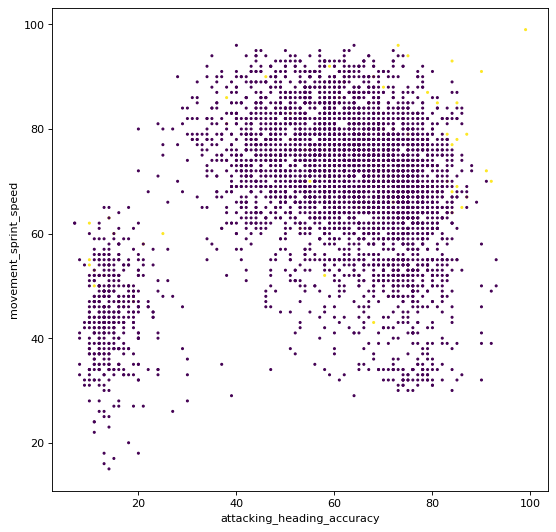

In [32]:
plt.figure(figsize=(8,8), dpi=80)
plt.scatter(df_skills[skill_1], y=df_skills[skill_2],s=3,c=bool_crack)
plt.xlabel(skill_1)
plt.ylabel(skill_2)
plt.show()

Gráfica con Plotly, más completa e interactiva pero un poco pesada

In [33]:
graf1 = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'club_name'], #'Height', 'Weight', 'Club', 'Age', 'Name','Position'
                           marker=dict(
                                size=5)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[graf1,crack]

layout = go.Layout(title="Visualización de la base de a dos variables numéricas",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=700,height=700)

fig = go.Figure(data=data, layout=layout)


In [35]:
iplot(fig)

Como hay muchas podibles combinaciones de 2 skills, elegimos un criterio para estudiar una cantidad razonable, por ejemplo, podemos estudiar los pares que estan mas correlacionados entre sí, segun el coeficiente de pearson

In [38]:
corr = df_skills.corr()
corr.head()

attacking_crossing  attacking_finishing  \
attacking_crossing                    1.000000             0.687154   
attacking_finishing                   0.687154             1.000000   
attacking_heading_accuracy            0.426463             0.430643   
attacking_short_passing               0.808603             0.684781   
attacking_volleys                     0.689452             0.898647   

                            attacking_heading_accuracy  \
attacking_crossing                            0.426463   
attacking_finishing                           0.430643   
attacking_heading_accuracy                    1.000000   
attacking_short_passing                       0.643728   
attacking_volleys                             0.444450   

                            attacking_short_passing  attacking_volleys  \
attacking_crossing                         0.808603           0.689452   
attacking_finishing                        0.684781           0.898647   
attacking_heading_accuracy                 0.643728           0.444450   
attacking_short_passing                    1.000000           0.686016   
attacking_volleys                          0.686016           1.000000   

                            skill_dribbling  skill_curve  skill_fk_accuracy  \
attacking_crossing                 0.872986     0.858827           0.749582   
attacking_finishing                0.828653     0.784889           0.728621   
attacking_heading_accuracy         0.535004     0.388327           0.320280   
attacking_short_passing            0.877627     0.773027           0.700544   
attacking_volleys                  0.803080     0.802923           0.745471   

                            skill_long_passing  skill_ball_control  \
attacking_crossing                    0.736931            0.849551   
attacking_finishing                   0.507776            0.793383   
attacking_heading_accuracy            0.507098            0.636155   
attacking_short_passing               0.883892            0.935880   
attacking_volleys                     0.523655            0.780800   

                            movement_acceleration  movement_sprint_speed  \
attacking_crossing                       0.663057               0.626041   
attacking_finishing                      0.579585               0.552664   
attacking_heading_accuracy               0.187326               0.276342   
attacking_short_passing                  0.519420               0.502849   
attacking_volleys                        0.522034               0.490466   

                            movement_agility  movement_reactions  \
attacking_crossing                  0.697090            0.166484   
attacking_finishing                 0.630074            0.235723   
attacking_heading_accuracy          0.120019            0.148866   
attacking_short_passing             0.564698            0.265071   
attacking_volleys                   0.601807            0.274919   

                            movement_balance  power_shot_power  power_jumping  \
attacking_crossing                  0.675111          0.522150      -0.026133   
attacking_finishing                 0.556988          0.738525      -0.032604   
attacking_heading_accuracy          0.085673          0.298675       0.345546   
attacking_short_passing             0.561258          0.516831       0.049217   
attacking_volleys                   0.542330          0.748192      -0.017568   

                            power_stamina  power_strength  power_long_shots  \
attacking_crossing               0.695894       -0.218780          0.771127   
attacking_finishing              0.525907       -0.111405          0.885267   
attacking_heading_accuracy       0.556779        0.467019          0.443352   
attacking_short_passing          0.750001       -0.000780          0.768753   
attacking_volleys                0.502746       -0.103164          0.868290   

                            mentality_aggression  mentality_interceptions  \
attack

Hacemos un mapa de calor para ver de la mas correlacionadas cual está correlacionada con cual y luego hacemos varios graficos de skill_1 vs skill_2 al mismo tiempo con seaborn

<AxesSubplot:>

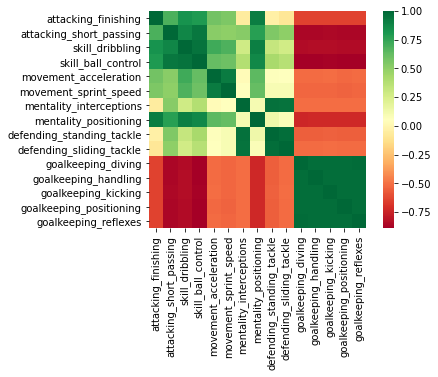

In [41]:
indices = corr[(corr.values>0.9) & (corr.values!=1)].index.unique()
corr_positiva = corr.loc[indices,indices]
sns.heatmap(corr_positiva, square=True, cmap='RdYlGn')

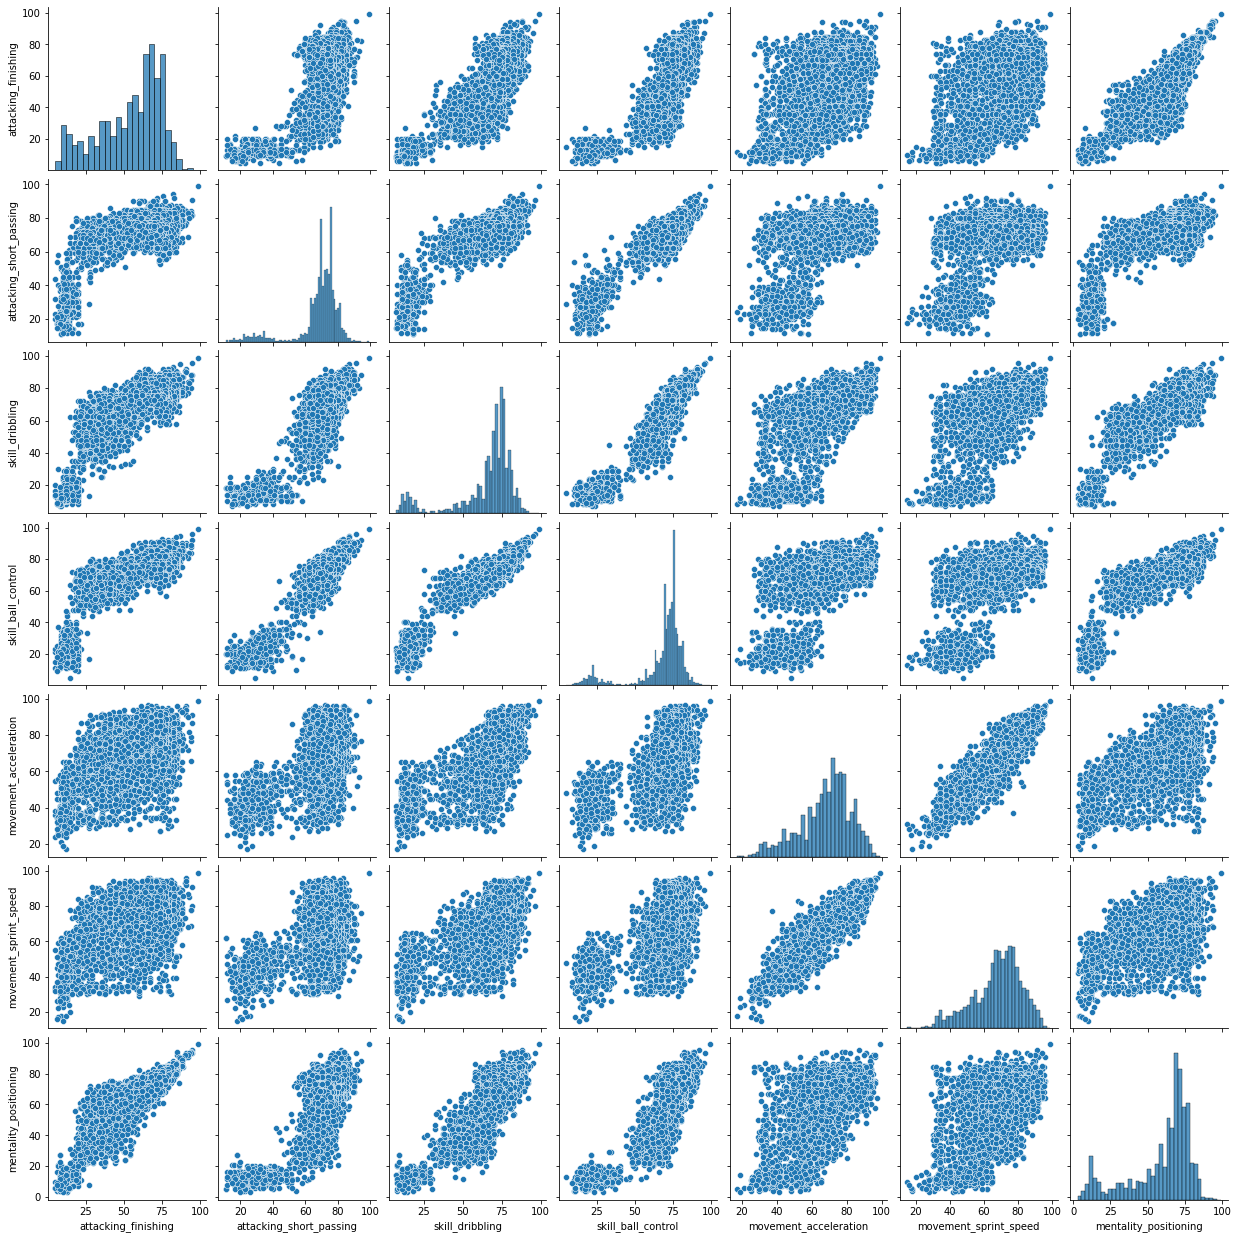

In [54]:
sns.pairplot(df_skills.loc[:,list(indices[:6]) + ['mentality_positioning']])

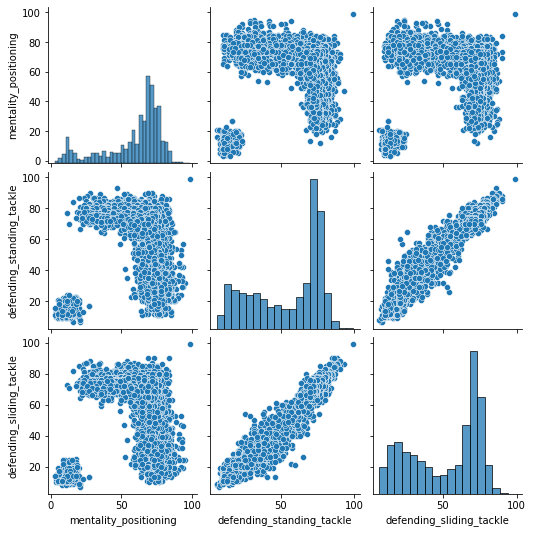

In [71]:
sns.pairplot(df_skills.loc[:,['mentality_positioning', 'defending_standing_tackle', 'defending_sliding_tackle']])

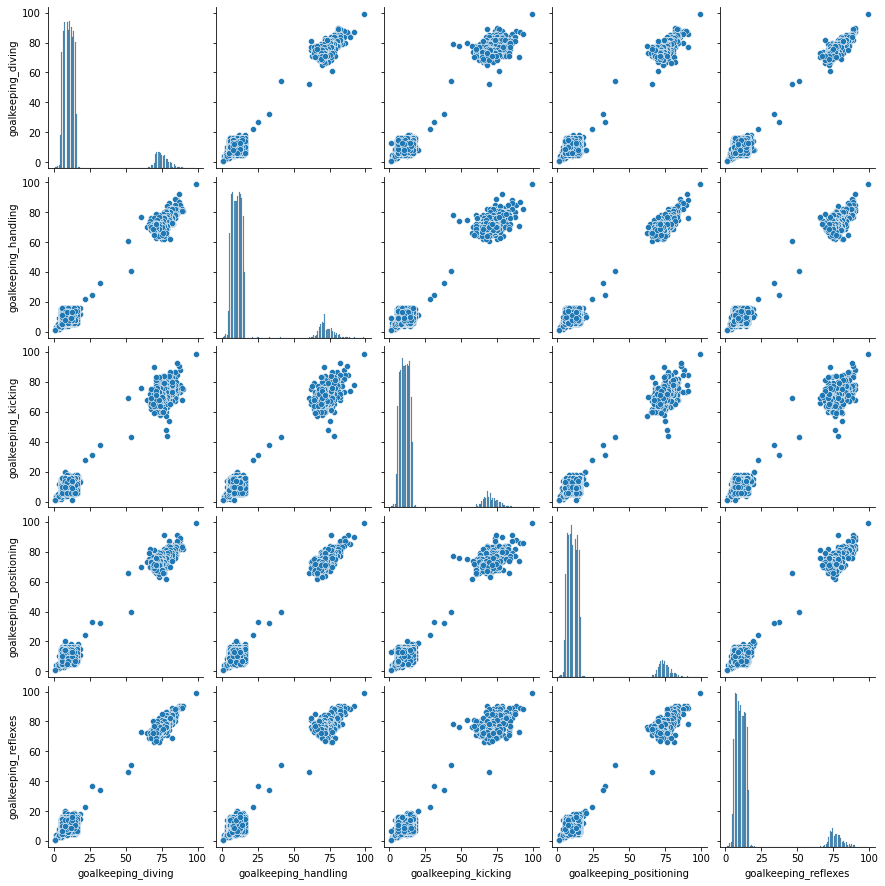

In [56]:
sns.pairplot(df_skills.iloc[:,-5:])

**Consigna de trabajo en grupo:** buscar agrupamientos de jugadores de manera intuitiva por cercanía (en espacios bidimensionales, de a dos variables por vez) y si se encuentran, tratar de explicarlos visualmente con alguna característica.

En el caso de los skills de arqueros (último pairplot) es claro que los dos clusters que se ven representan a arqueros por un lado y el resto de los jugadores por el otro. Para ver esto realizamos el mismo pairplot pero coloreando por posición del jugador.

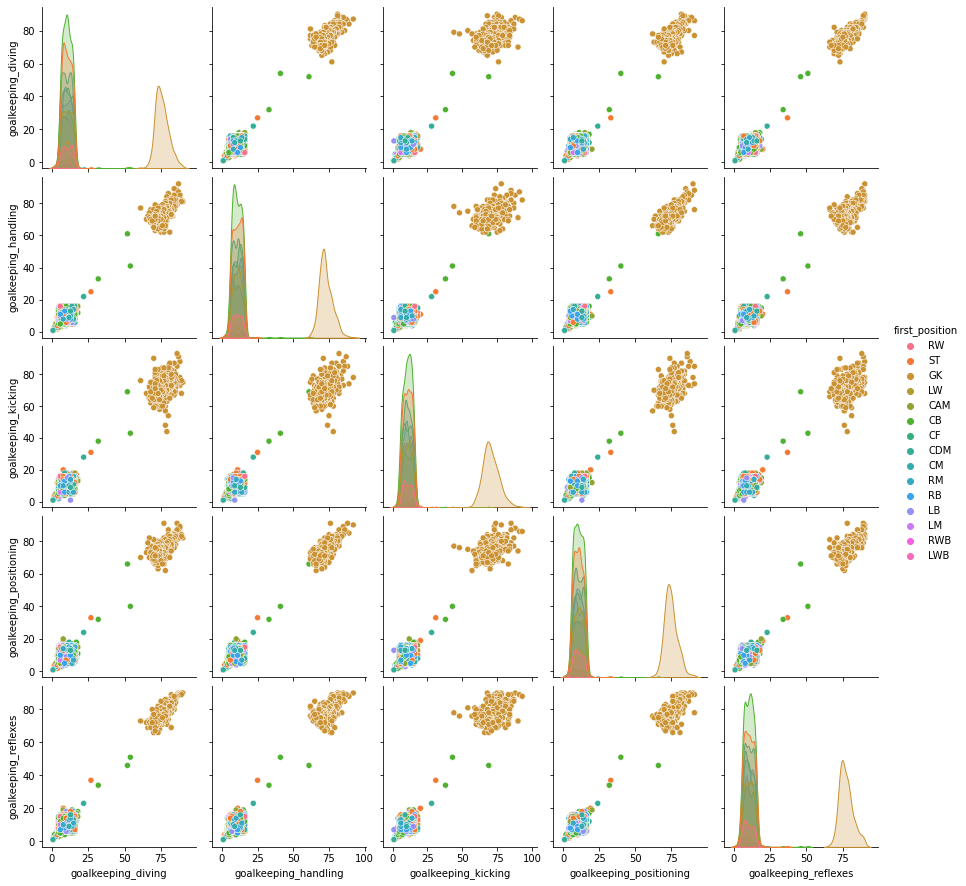

In [62]:
sns.pairplot(data=df_skills_pos, hue='first_position', vars=['goalkeeping_diving', 'goalkeeping_handling', 
                'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes'])

Para analizar los otros dos pairplots y ver si hay alguna relación entre los valores de las skills y las posiciones de los jugadores que no son arqueros, vamos a agrupar las posiciones en 3 grupos: defensores, mediocampo y delanteros

In [65]:
dict_pos = {'CB':'Defensor', 'RB':'Defensor', 'LB':'Defensor', 'RWB':'Defensor', 'LWB':'Defensor',
        'CM':'Mediocampo', 'CDM':'Mediocampo', 'CAM':'Mediocampo', 'RM':'Mediocampo', 'LM':'Mediocampo', 
        'ST':'Delantero', 'CF':'Delantero', 'RF':'Delantero', 'LF':'Delantero', 'RW':'Delantero', 'LW': 'Delantero',
        'GK':'Arquero'}
df_skills_pos['type_position'] = df_skills_pos['first_position'].replace(dict_pos)

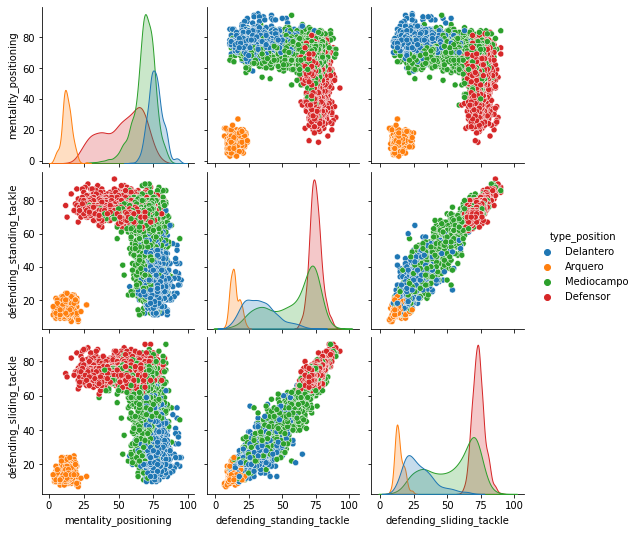

In [70]:
sns.pairplot(data=df_skills_pos, hue='type_position', 
             vars=['mentality_positioning', 'defending_standing_tackle', 'defending_sliding_tackle'])

Ahora se puede ver claramente para cada una de de las skills, que ciertas posiciones requieren que el jugador sea mejor en una, mejor en la otra o que tenga un buen balance de ambas. Por ejemplo, los delanteros son muy buenos posicionandose pero malos en standing_tackle, mientras que los defensores al revés y los mediocampistas suelen ser buenos en ambas o por lo menos posicionandose.

En el otro pairplot también se puede observar que para algunos pares de skills hay claras distinciones entre los 4 tipos de posiciones

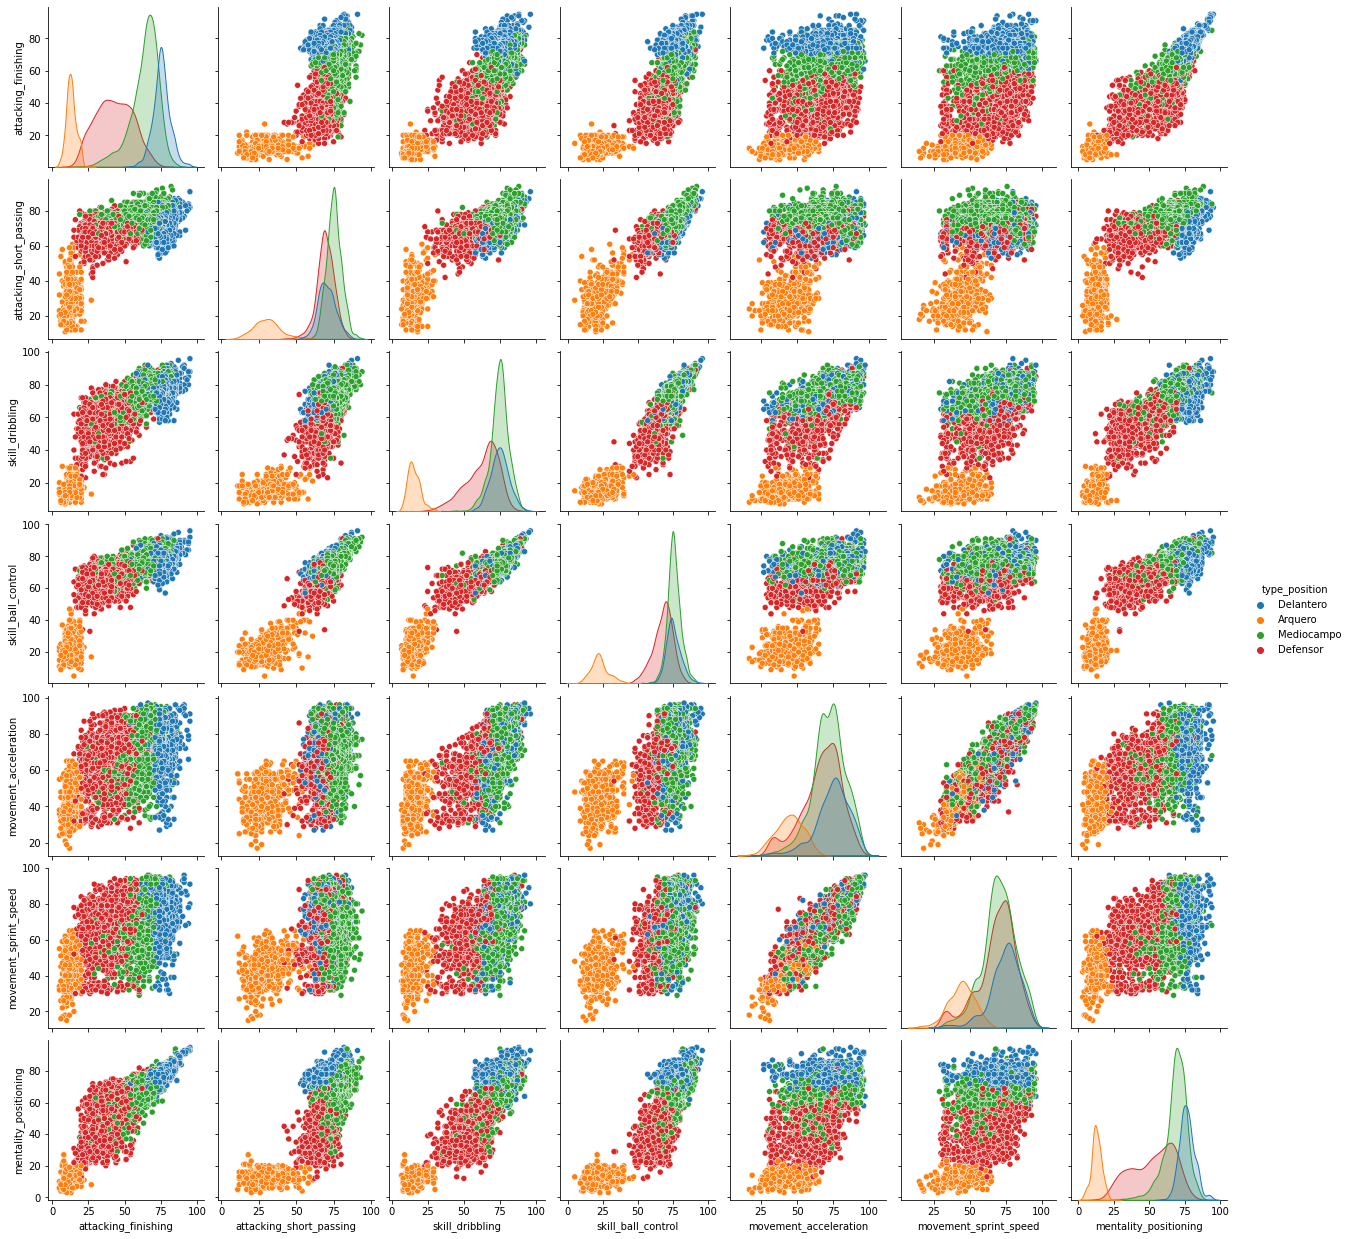

In [72]:
sns.pairplot(data=df_skills_pos, hue='type_position', 
             vars=['attacking_finishing', 'attacking_short_passing', 'skill_dribbling', 'skill_ball_control', 
                   'movement_acceleration', 'movement_sprint_speed','mentality_positioning'])

En próxima gráfica, también se diferencian los mejores jugadores y alguna característica de interés 

Se puede ubicar también un jugador en particular. Con la siguiente linea de comando, por ejemplo, Leo Messi: 

In [73]:
#P/Gráfico 2

#Elegimos un jugador
recherche_joueur=df_n["short_name"]=='L. Messi' 
#recherche_joueur=df_n["Name"]==df_n["Name"][4000] # acá podemos elegir otro 

bool_crack=df_n["overall"] > 85
bool_elecc=df_n["club_name"]=='FC Barcelona' 
bool_no_crack=df_n["overall"]<86
bool_machinegun=df_n["short_name"]=='MachineGun'

#Elegir dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[2]  #6
skill_2=skills_ratings[11]  #25

Gráfica con plotly

In [76]:
palette=['navy','red','#A2D5F2','orange','green','pink']  

data=[]

n_crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Crack',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=15,color='black'),
                      opacity=0.9,marker=dict(color=palette[2],size=7),mode='markers+text')

n_no_crack =go.Scatter(x=df_skills.loc[bool_no_crack,skill_1], y=df_skills.loc[bool_no_crack,skill_2],name='Average player',
                         text=df_n.loc[bool_no_crack,'short_name'],
                         opacity=0.6,marker=dict(color=palette[1],size=3),mode='markers')
n_elecc=go.Scatter(x=df_skills.loc[bool_elecc,skill_1], y=df_skills.loc[bool_elecc,skill_2],name='FC Barcelona',
                         text=df_n.loc[bool_elecc,'short_name'],
                         opacity=0.6,marker=dict(color=palette[0],size=5),mode='markers')

n_machinegun =go.Scatter(x=df_skills.loc[bool_machinegun,skill_1], y=df_skills.loc[bool_machinegun,skill_2],name='Perfect player',
                           textfont=dict(family='sans serif',size=20,color='black'),
                           opacity=0.6,marker=dict(color=palette[3],size=30),mode='markers+text')


joueur_recherche =go.Scatter(x=df_skills.loc[recherche_joueur,skill_1], y=df_skills.loc[recherche_joueur,skill_2],name='Searched player',
                           text=df_n.loc[recherche_joueur,'short_name'],
                            textfont=dict(family='sans serif',size=20,color='black'),
                           opacity=1,marker=dict(color=palette[4],size=40),mode='markers+text')

data=[n_no_crack,n_elecc
      ,n_crack,n_machinegun,joueur_recherche]

layout = go.Layout(title="Fifa Players",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)


In [77]:
#En Jupyter ntb
iplot(fig)  #muestra aquí